In [431]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob
import pandas as pd
from matplotlib import gridspec

Data_Folder = "Test"
Test_Files = glob.glob(os.path.join(Data_Folder, "*", "test.txt"))[2:]

In [432]:
def Load_Files(start, end = None):
    """
    start: <int> OR <array>, start index of desired range or array of desired indexes
    end: <int> end index of desired range (not included)
    """
    if type(start) == int:
        df =  pd.read_csv(Test_Files[start], sep="\t", header = 9)

        if type(end) == int:
            for file in Test_Files[start+1:end]:
                df = pd.concat([df, pd.read_csv(file, sep="\t", header = 9)], ignore_index=True)
    else:
        df = pd.read_csv(Test_Files[start[0]], sep="\t", header = 9)
        for index in start[1:]:
            df = pd.concat([df, pd.read_csv(Test_Files[index], sep="\t", header = 9)], ignore_index=True)

    return df

df = Load_Files(0)

In [433]:
def Group_Gate_Voltage(df):

    # Step 1: Create a sign label
    df['label'] = df['Gate Voltage (V)'].apply(lambda x: 'positive' if x > 0.001 else 'zero' if -0.001 < x < 0.001 else 'negative')
    
    # Step 2: Mark boundaries between different labels
    df['group'] = (df['label'] != df['label'].shift()).cumsum()
    df['FileNr'] = (df['Time (s)'] == 0).cumsum()
    
    # Step 3: Post-process zero groups
    group_labels = df.groupby('group')['label'].first()
    
    # Create mapping: group_id → new label
    new_labels = {}
    
    for group_id, label in group_labels.items():
        if label == 'zero':
            prev_label = group_labels.get(group_id - 1, None)
            if prev_label == 'positive':
                new_labels[group_id] = 'zero-p'
            elif prev_label == 'negative':
                new_labels[group_id] = 'zero-n'
            else:
                new_labels[group_id] = 'zero'  # fallback
        else:
            new_labels[group_id] = label
    
    # Apply new labels
    df['label'] = df['group'].map(new_labels)
    df = df.drop(df[df['Time (s)']<0.001].index)
    return df

df = Group_Gate_Voltage(df)

def Disp_Group(df, limit=np.inf):
    grouped = df.groupby(['group', 'label'])
    for (group_id, label), group_df in grouped:
        print(f"Group {group_id} ({label}):")
        print(group_df)
        print()
        if group_id > limit:
            break

Disp_Group(df, 0)

Group 2 (positive):
   Time (s)  Gate Voltage (V)  Drain Current (A)  Gate Current (A)     label  \
1  0.110910          0.799963           0.000467     -8.293030e-10  positive   
2  0.260046          0.800000           0.000468      8.812630e-07  positive   
3  0.393191          0.800000           0.000467      8.784510e-07  positive   
4  0.514119          0.799999           0.000466      8.750340e-07  positive   
5  0.642905          0.799999           0.000466      8.717980e-07  positive   
6  0.773961          0.799998           0.000465      8.683220e-07  positive   
7  0.903541          0.799998           0.000464      8.650490e-07  positive   
8  1.026552          0.800001           0.000464      8.616390e-07  positive   

   group  FileNr  
1      2       1  
2      2       1  
3      2       1  
4      2       1  
5      2       1  
6      2       1  
7      2       1  
8      2       1  



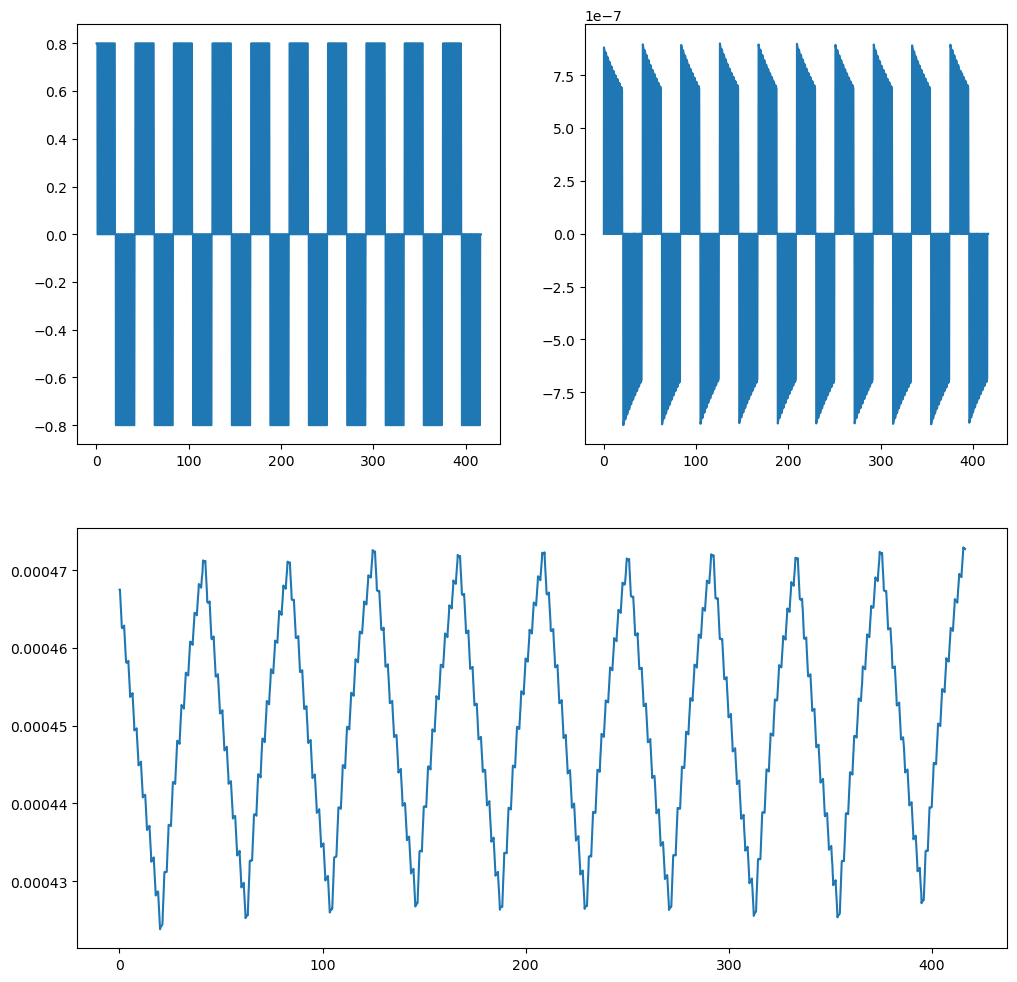

In [434]:
def df_Plot(df):
    fig = plt.figure(
    figsize = (12, 12))
    gs = gridspec.GridSpec(2, 2)
    
    ax1 = plt.subplot(gs[0, 0])
    ax2 = plt.subplot(gs[0, 1])
    ax3 = plt.subplot(gs[1, 0:2])
    grouped = df.groupby(['FileNr'])
    for group_id, group_df in grouped:
        ax1.plot(group_df["Time (s)"], group_df['Gate Voltage (V)'])
        ax2.plot(group_df["Time (s)"], group_df['Gate Current (A)'])
        ax3.plot(group_df["Time (s)"], group_df['Drain Current (A)'])

df_Plot(df)

In [435]:
def Reset_Time(df):
    grouped = df.groupby(['group', 'label'])
    for (group_id, label), group in grouped:
        df.loc[df['group']==group_id, 'Time (s)'] = group['Time (s)']-group['Time (s)'].iloc[0]
    return df

df = Reset_Time(df)
Disp_Group(df, 0)

Group 2 (positive):
   Time (s)  Gate Voltage (V)  Drain Current (A)  Gate Current (A)     label  \
1  0.000000          0.799963           0.000467     -8.293030e-10  positive   
2  0.149136          0.800000           0.000468      8.812630e-07  positive   
3  0.282281          0.800000           0.000467      8.784510e-07  positive   
4  0.403210          0.799999           0.000466      8.750340e-07  positive   
5  0.531995          0.799999           0.000466      8.717980e-07  positive   
6  0.663051          0.799998           0.000465      8.683220e-07  positive   
7  0.792631          0.799998           0.000464      8.650490e-07  positive   
8  0.915643          0.800001           0.000464      8.616390e-07  positive   

   group  FileNr  
1      2       1  
2      2       1  
3      2       1  
4      2       1  
5      2       1  
6      2       1  
7      2       1  
8      2       1  



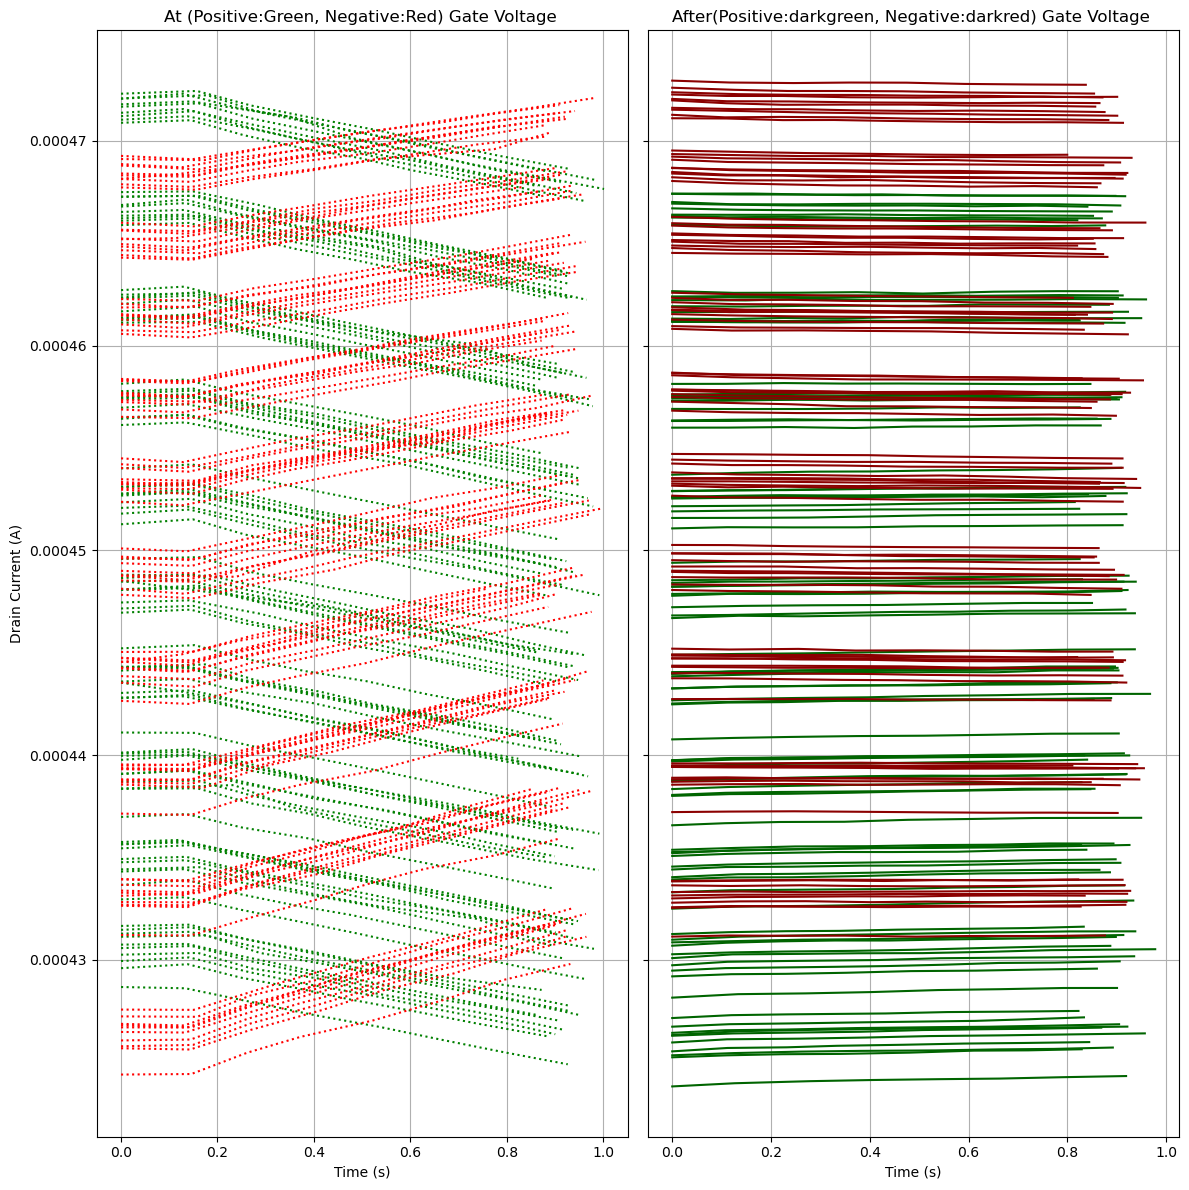

In [436]:
def Plot_Grouped(df, ax, label):
    colors = {'positive': 'green', 'zero-p': 'darkgreen', 'zero-n': 'darkred', 'negative': 'red', 'zero': 'black'}
    linestyles = {'0.0': '-', '0.9': ':', '0.8': ':', '0.3': '--', '0.1': '-.', '0.03':' ', '0.09': '-.'}
    for _, group_df in df[df['label']==label].groupby('group'):
        ax.plot(group_df['Time (s)'], group_df['Drain Current (A)'], 
        label=group_df['label'].iloc[0], 
        color=colors[group_df['label'].iloc[0]],
        linestyle = linestyles[str(round(abs(float(group_df['Gate Voltage (V)'].iloc[0])), 2))])
    



def Plot_Group_df(df):
    fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(12, 12), tight_layout = True)\
    
    Plot_Grouped(df, ax1, 'positive')
    Plot_Grouped(df, ax1, 'negative')
    
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Drain Current (A)')
    ax1.set_title('At (Positive:Green, Negative:Red) Gate Voltage ')
    ax1.grid(True)
    
    Plot_Grouped(df, ax2, 'zero-p')
    Plot_Grouped(df, ax2, 'zero-n')
    Plot_Grouped(df, ax2, 'zero')

    ax2.set_xlabel('Time (s)')
    ax2.set_title('After(Positive:darkgreen, Negative:darkred) Gate Voltage ')
    ax2.grid(True)

    plt.show()

Plot_Group_df(df)

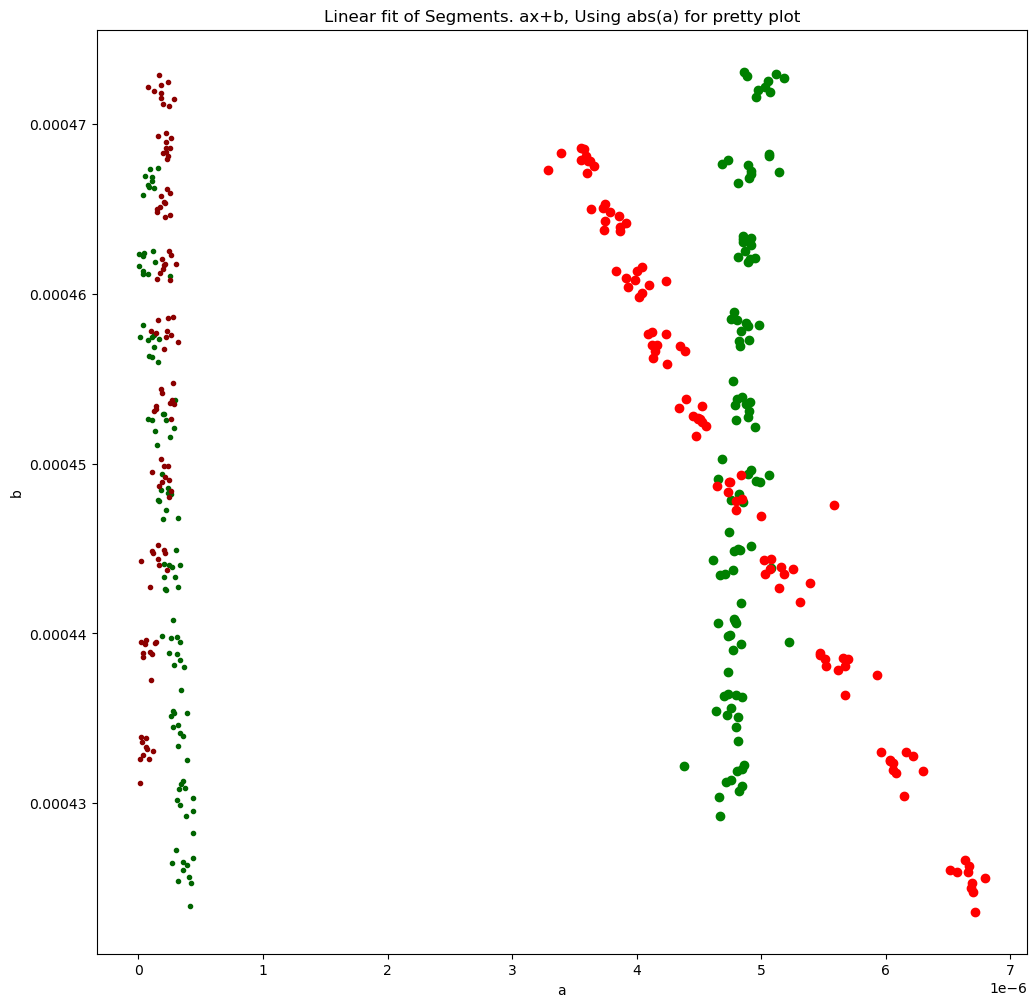

In [437]:
def Lin_Fit(df, label):
    filled_markers = ('.', 'o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
    markerstyles = {'0.0': '.', '0.9': 'o', '0.8': 'o', '0.3': 'v', '0.1': 'd', '0.03':'*'}
    fit_m = []
    fit_b = []
    voltage = []
    
    for _, group_df in df[df['label']==label].groupby('group'):
        if group_df.shape[0] > 1:
            group_df['Time (s)'] = group_df['Time (s)']
            #group_df = group_df.iloc[1:]
            m, b = np.polyfit(group_df['Time (s)'].iloc[1:], group_df['Drain Current (A)'].iloc[1:], 1)
            fit_m.append(m)
            fit_b.append(b)
            voltage.append(str(round(abs(float(group_df['Gate Voltage (V)'].iloc[0])), 2)))
    markerstyle = np.vectorize(markerstyles.get)(voltage)

    return fit_m, fit_b, markerstyle

def Plot_Lin_Fit(df, label):
    colors = {'positive': 'green', 'zero-p': 'darkgreen', 'zero-n': 'darkred', 'negative': 'red', 'zero': 'black'}
    
    fit_m, fit_b, markerstyle = Lin_Fit(df, label)
    for i in range(len(markerstyle)):
        plt.scatter(abs(fit_m[i]), fit_b[i], marker = markerstyle[i], color = colors[label])
    
    
def Plot_Lin_Fit_All(df):
    fig = plt.figure(figsize = (12,12))
    for label in ['positive', 'negative', 'zero-p', 'zero-n', 'zero']:
        if sum(df['label']==label) > 0:
            Plot_Lin_Fit(df, label)
    plt.xlabel("a")
    plt.ylabel("b")
    plt.title("Linear fit of Segments. ax+b, Using abs(a) for pretty plot")
    plt.show()

Plot_Lin_Fit_All(df)

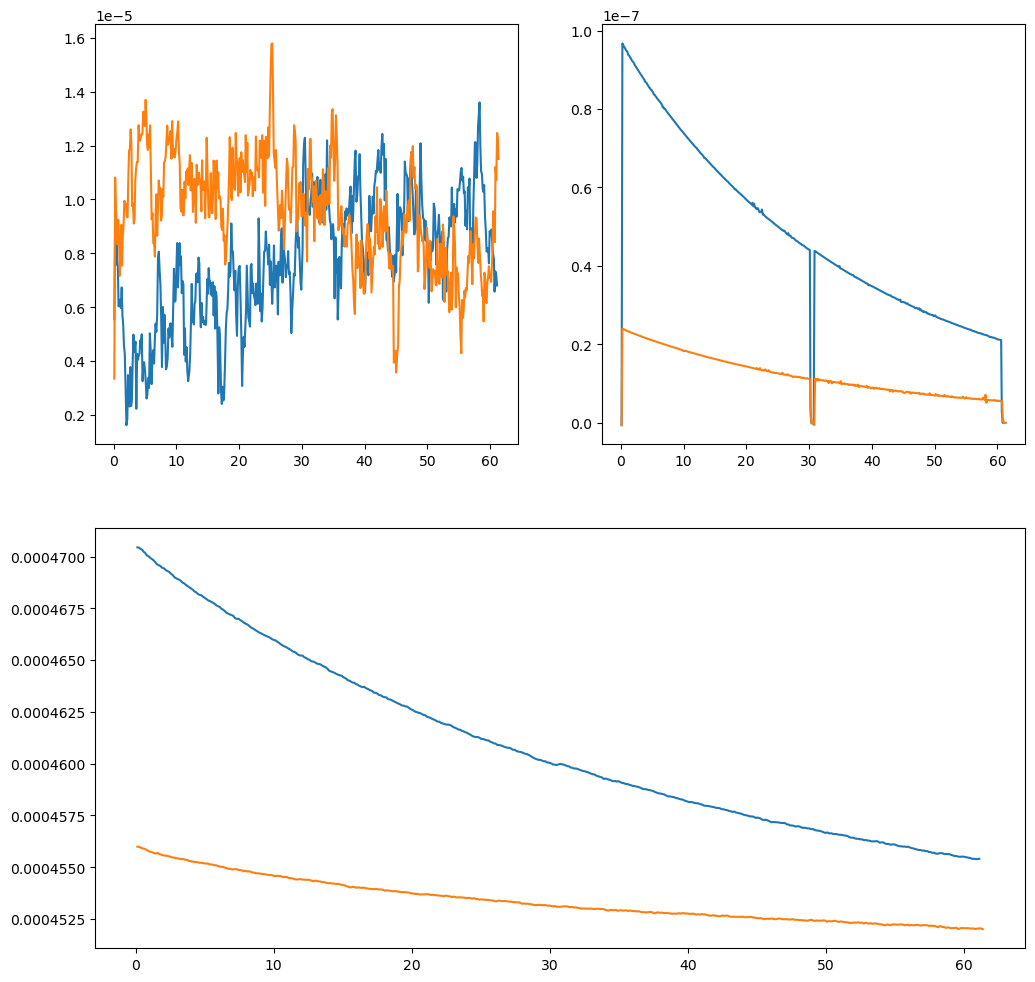

In [438]:
# Special 0 Voltage applied but gate is open (discharge)
df = Load_Files(1,3)
df = Group_Gate_Voltage(df)
df_Plot(df)

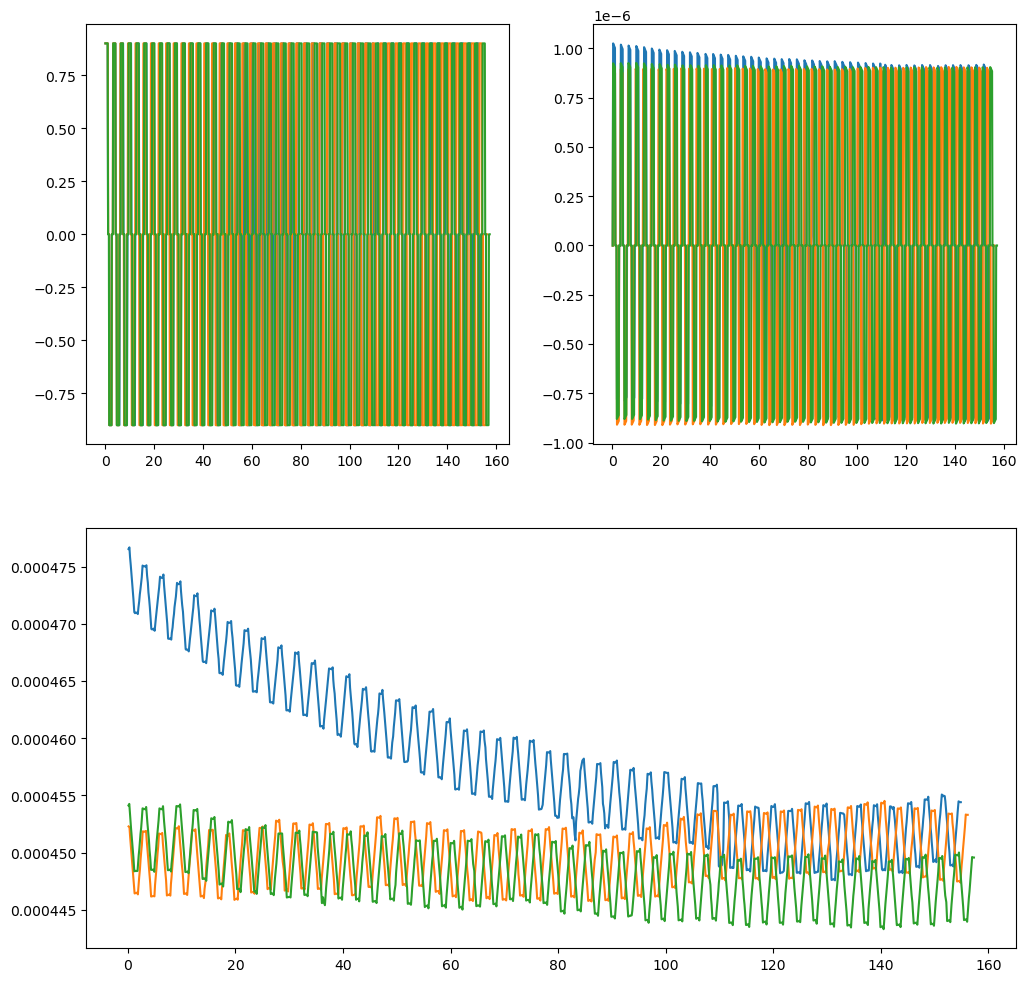

In [439]:
df = Load_Files([12, 3, 14])
df = Group_Gate_Voltage(df)
df_Plot(df)
#df_Plot(df[df['Time (s)']<10])

Group 2 (positive):
   Time (s)  Gate Voltage (V)  Drain Current (A)  Gate Current (A)     label  \
1  0.000000          0.900001           0.000477     -3.864880e-10  positive   
2  0.168301          0.900001           0.000477      1.024520e-06  positive   
3  0.284407          0.900001           0.000476      1.020630e-06  positive   
4  0.419721          0.899999           0.000475      1.016640e-06  positive   
5  0.538239          0.899999           0.000474      1.012880e-06  positive   
6  0.666591          0.899997           0.000474      1.008950e-06  positive   
7  0.801752          0.899997           0.000473      1.005120e-06  positive   
8  0.924524          0.899999           0.000472      1.001370e-06  positive   

   group  FileNr  
1      2       1  
2      2       1  
3      2       1  
4      2       1  
5      2       1  
6      2       1  
7      2       1  
8      2       1  



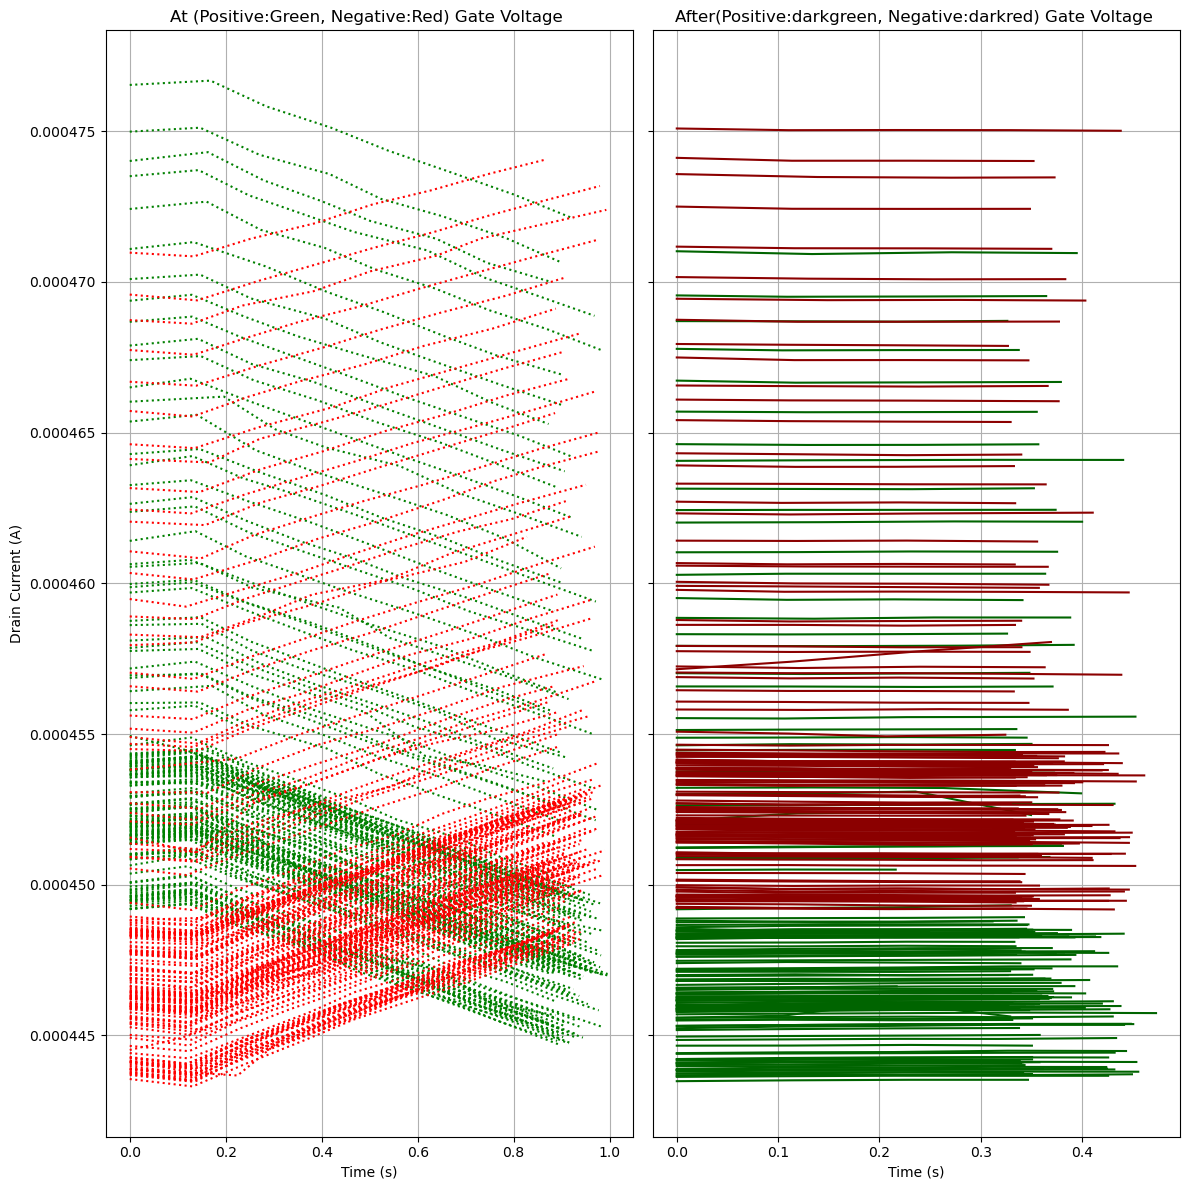

In [440]:
df = Reset_Time(df)
Disp_Group(df, 0)
Plot_Group_df(df)

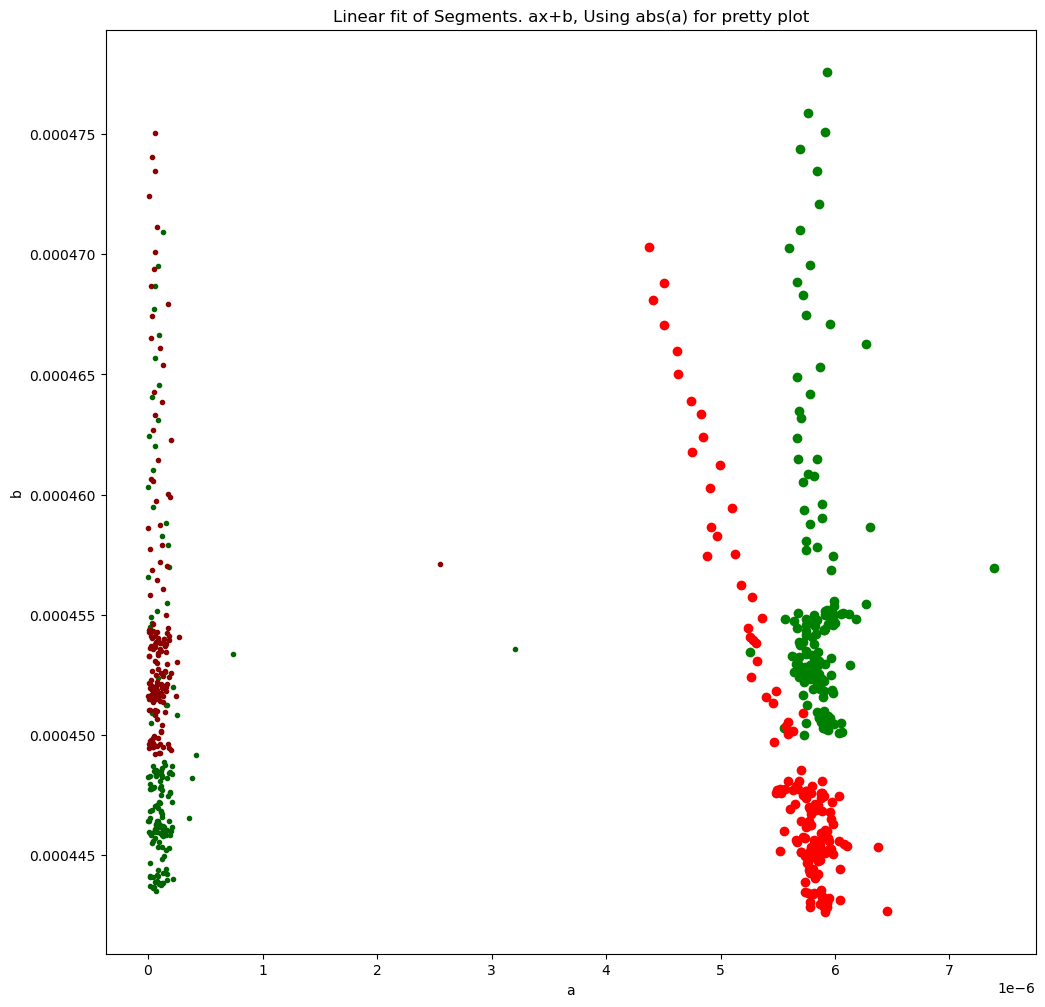

In [441]:
Plot_Lin_Fit_All(df)

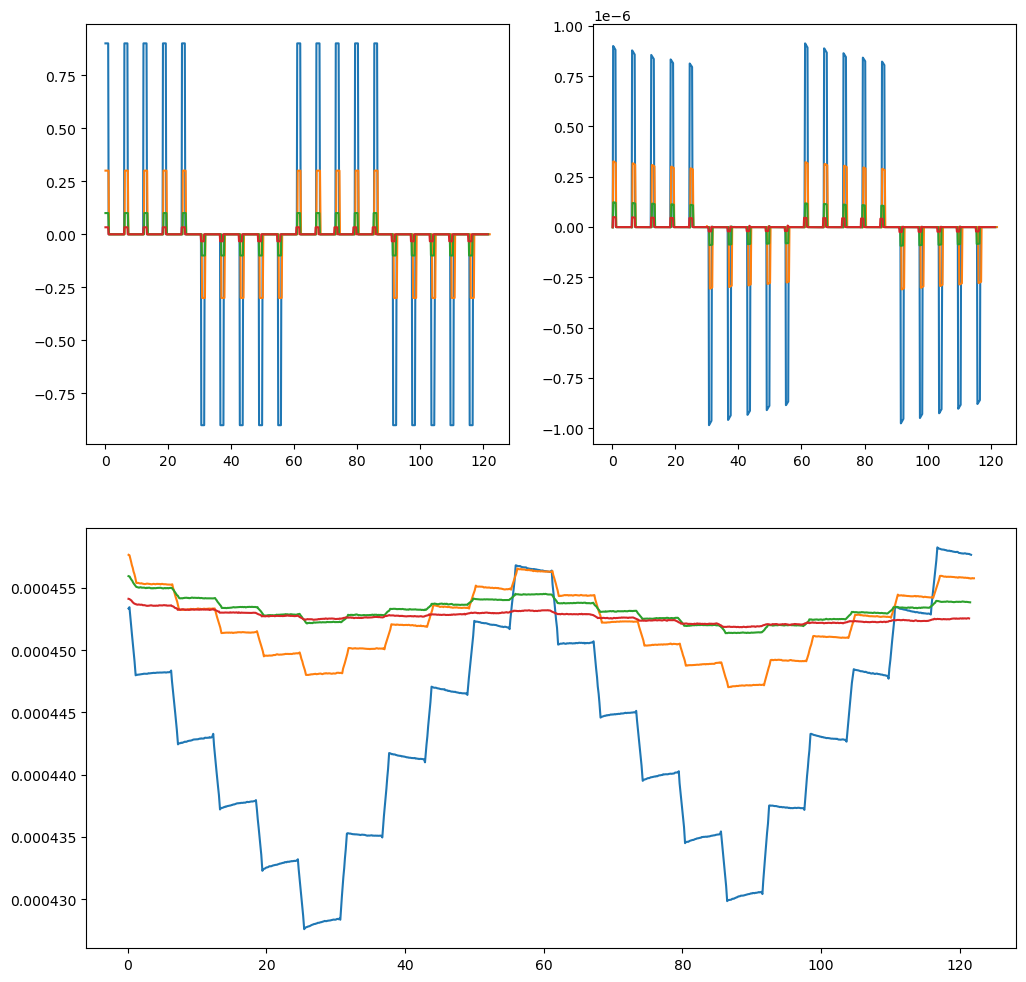

In [442]:
df = Load_Files(4, 8)
df = Group_Gate_Voltage(df)
df_Plot(df)

Group 2 (positive):
   Time (s)  Gate Voltage (V)  Drain Current (A)  Gate Current (A)     label  \
1  0.000000          0.899959           0.000453     -5.334020e-10  positive   
2  0.135127          0.899996           0.000453      8.999220e-07  positive   
3  0.257822          0.899996           0.000453      8.972360e-07  positive   
4  0.381134          0.899997           0.000452      8.939080e-07  positive   
5  0.500843          0.899997           0.000451      8.907160e-07  positive   
6  0.625993          0.899999           0.000451      8.872760e-07  positive   
7  0.741118          0.899998           0.000450      8.843320e-07  positive   
8  0.868137          0.899997           0.000449      8.810040e-07  positive   

   group  FileNr  
1      2       1  
2      2       1  
3      2       1  
4      2       1  
5      2       1  
6      2       1  
7      2       1  
8      2       1  



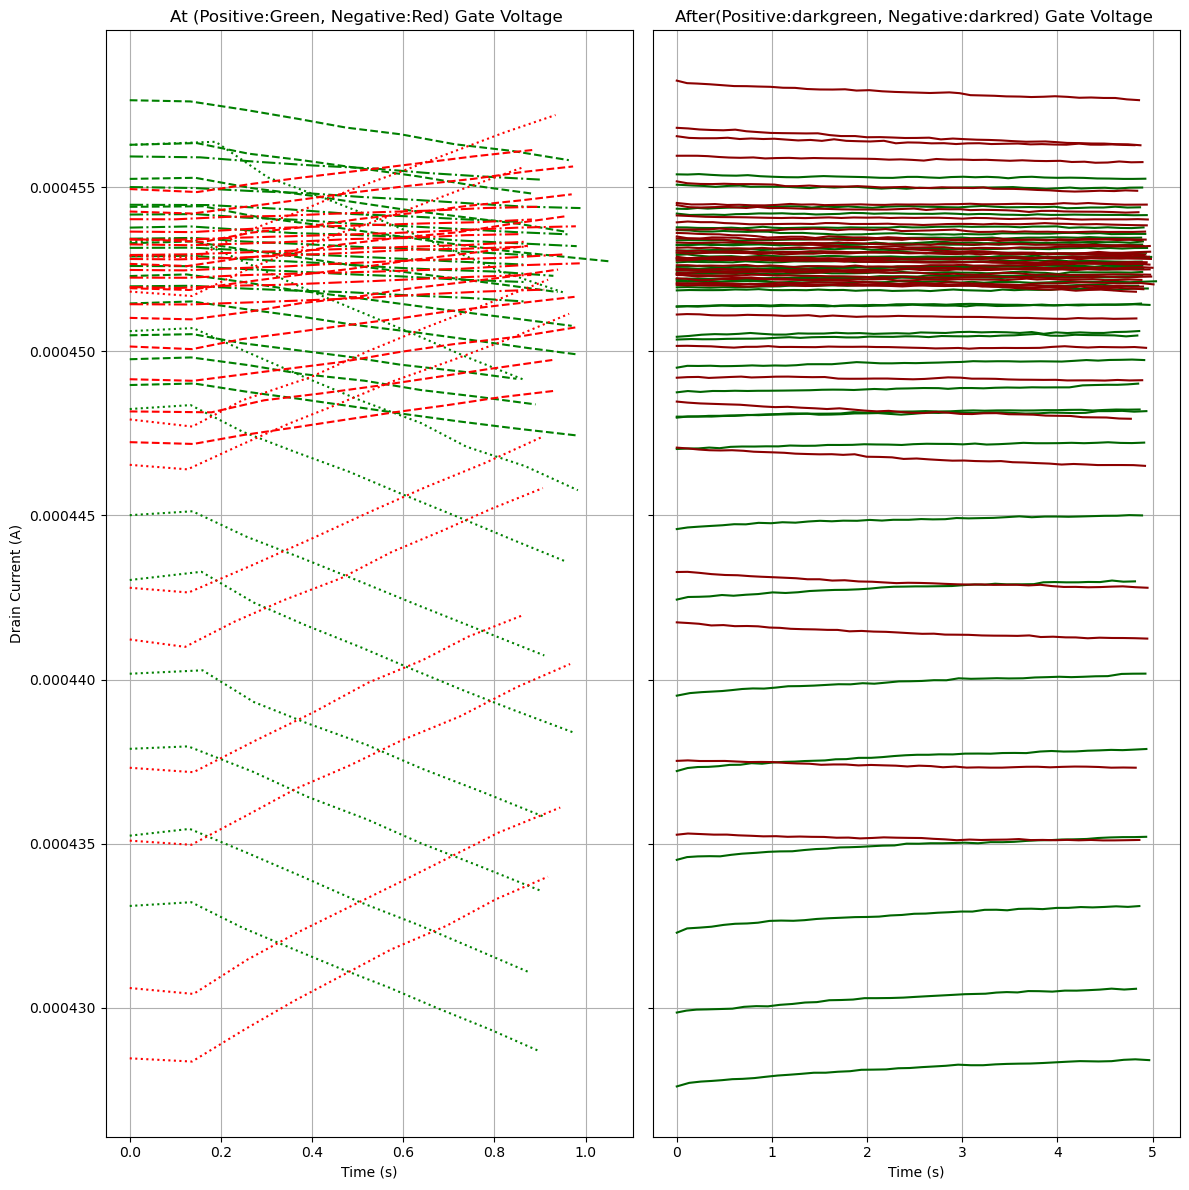

In [443]:
df = Reset_Time(df)
Disp_Group(df, 0)
Plot_Group_df(df)

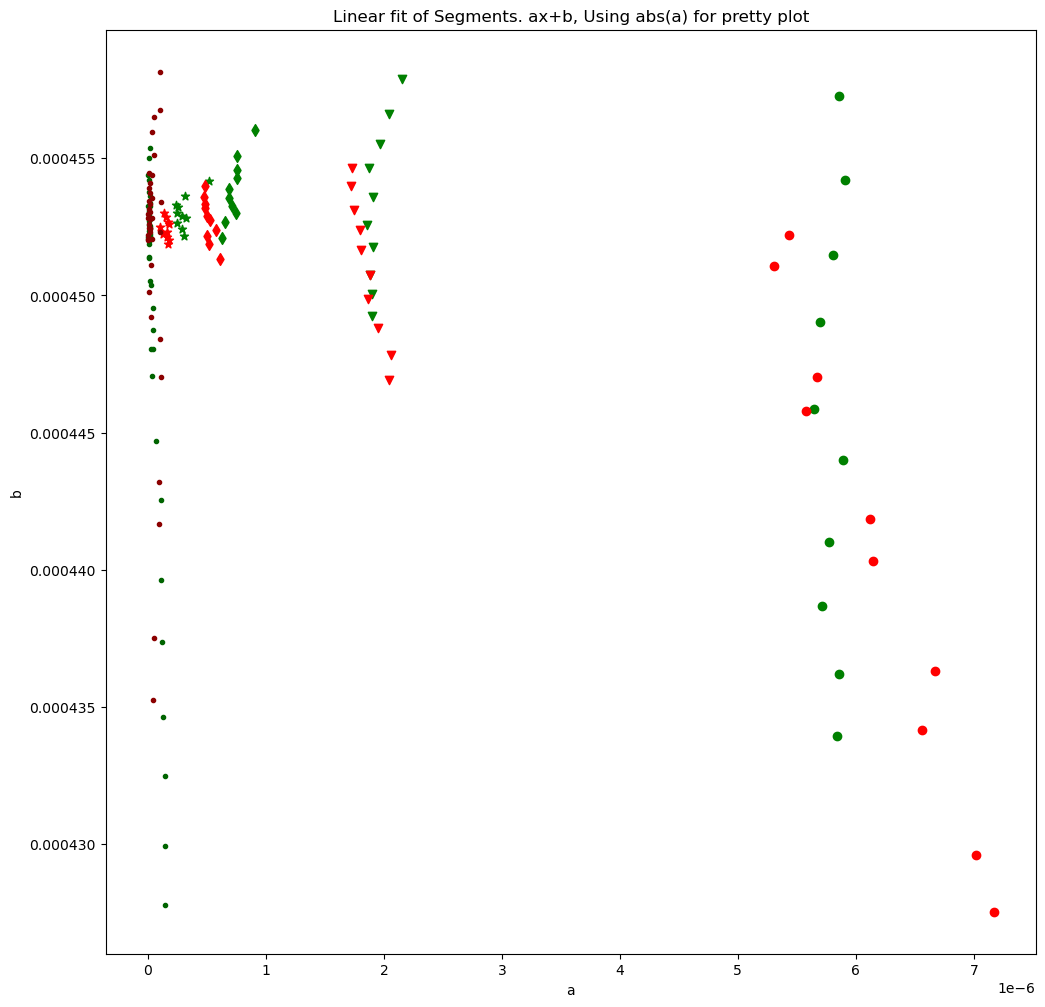

In [444]:
Plot_Lin_Fit_All(df)

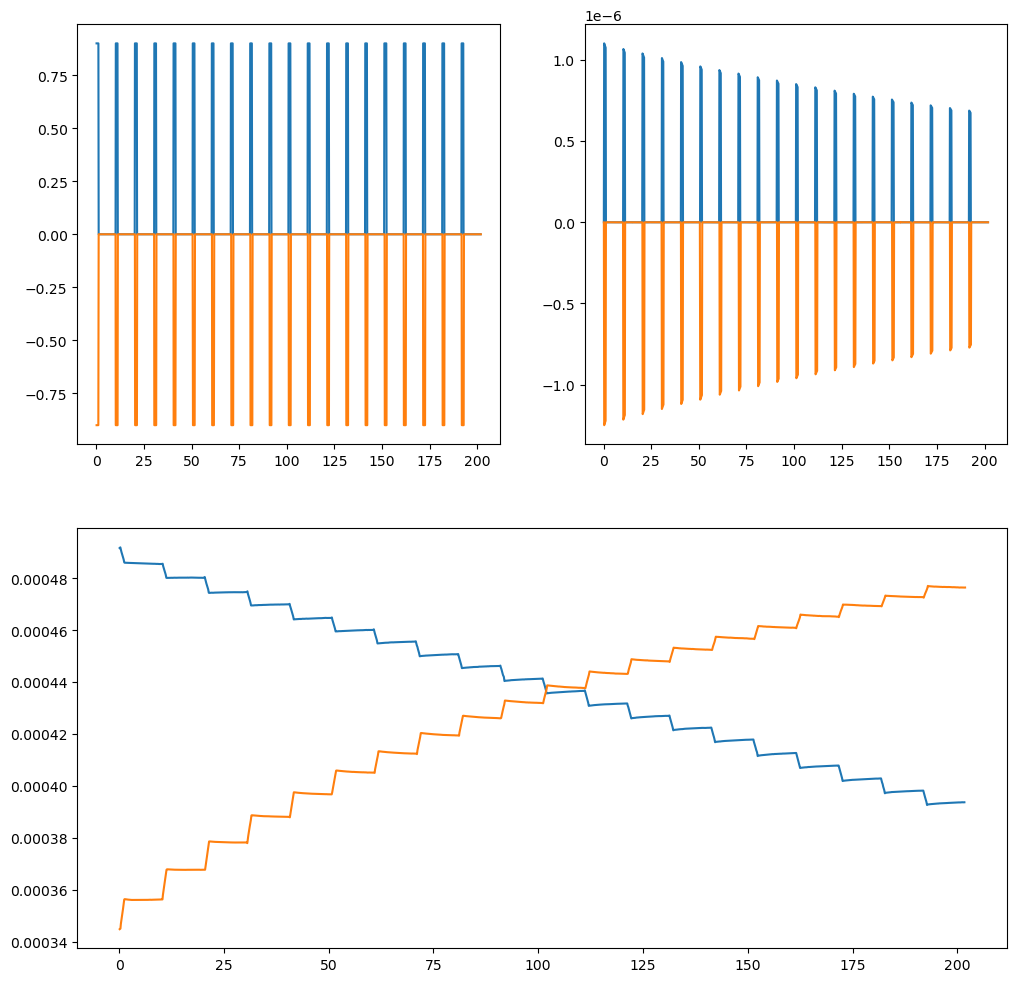

In [445]:
df = Load_Files([9, 11])
df = Group_Gate_Voltage(df)
df_Plot(df)

Group 2 (positive):
   Time (s)  Gate Voltage (V)  Drain Current (A)  Gate Current (A)     label  \
1  0.000000          0.899956           0.000492     -3.400210e-10  positive   
2  0.171075          0.899995           0.000492      1.102020e-06  positive   
3  0.308580          0.899994           0.000491      1.097330e-06  positive   
4  0.424759          0.899994           0.000490      1.093060e-06  positive   
5  0.528767          0.899993           0.000490      1.089430e-06  positive   
6  0.631925          0.899996           0.000489      1.086060e-06  positive   
7  0.742974          0.899994           0.000488      1.082350e-06  positive   
8  0.852470          0.899993           0.000488      1.078860e-06  positive   
9  0.959611          0.899994           0.000487      1.075310e-06  positive   

   group  FileNr  
1      2       1  
2      2       1  
3      2       1  
4      2       1  
5      2       1  
6      2       1  
7      2       1  
8      2       1  
9      2

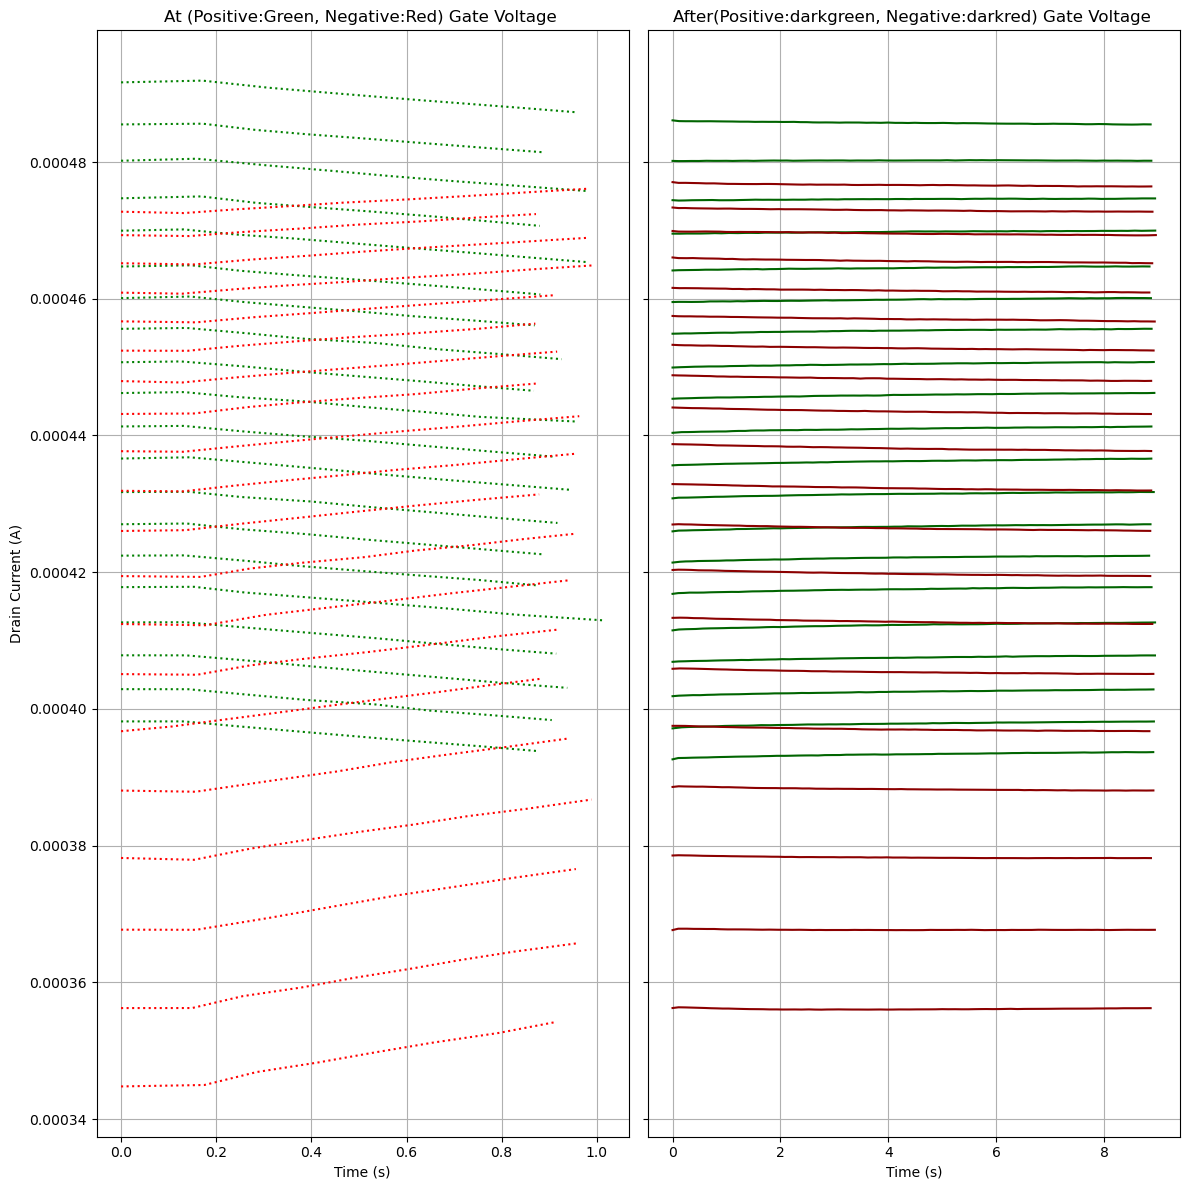

In [446]:
df = Reset_Time(df)
Disp_Group(df, 0)
Plot_Group_df(df)

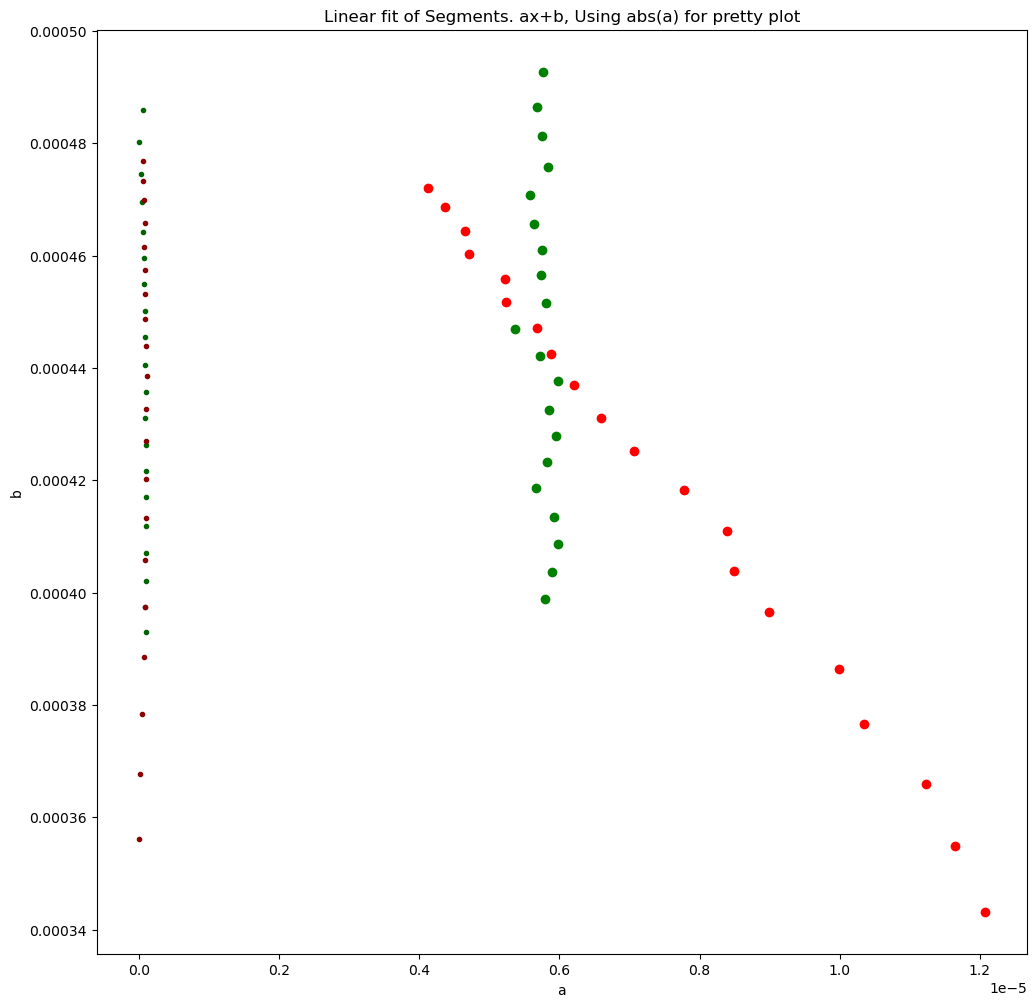

In [447]:
Plot_Lin_Fit_All(df)

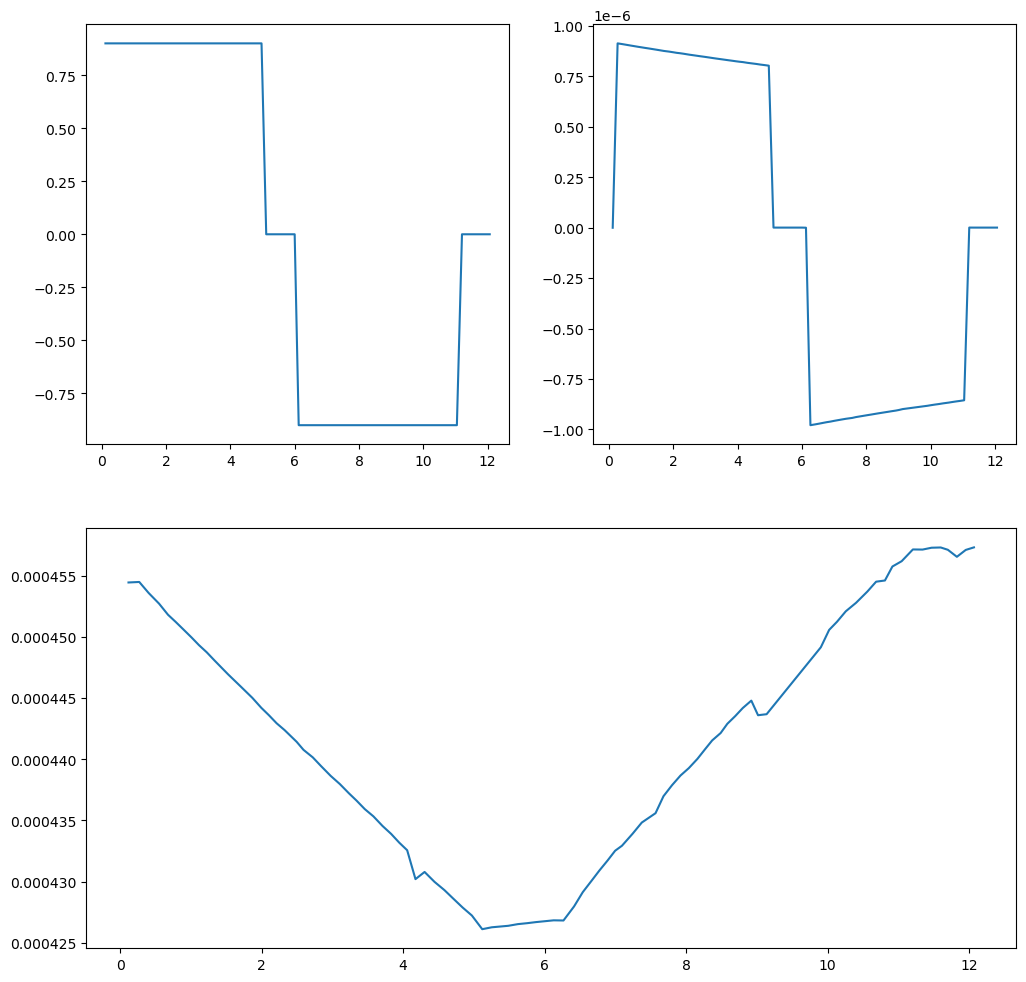

In [448]:
df = Load_Files([13])
df = df.drop(df[df['Time (s)']<0.001].index)
df = Group_Gate_Voltage(df)
df_Plot(df)

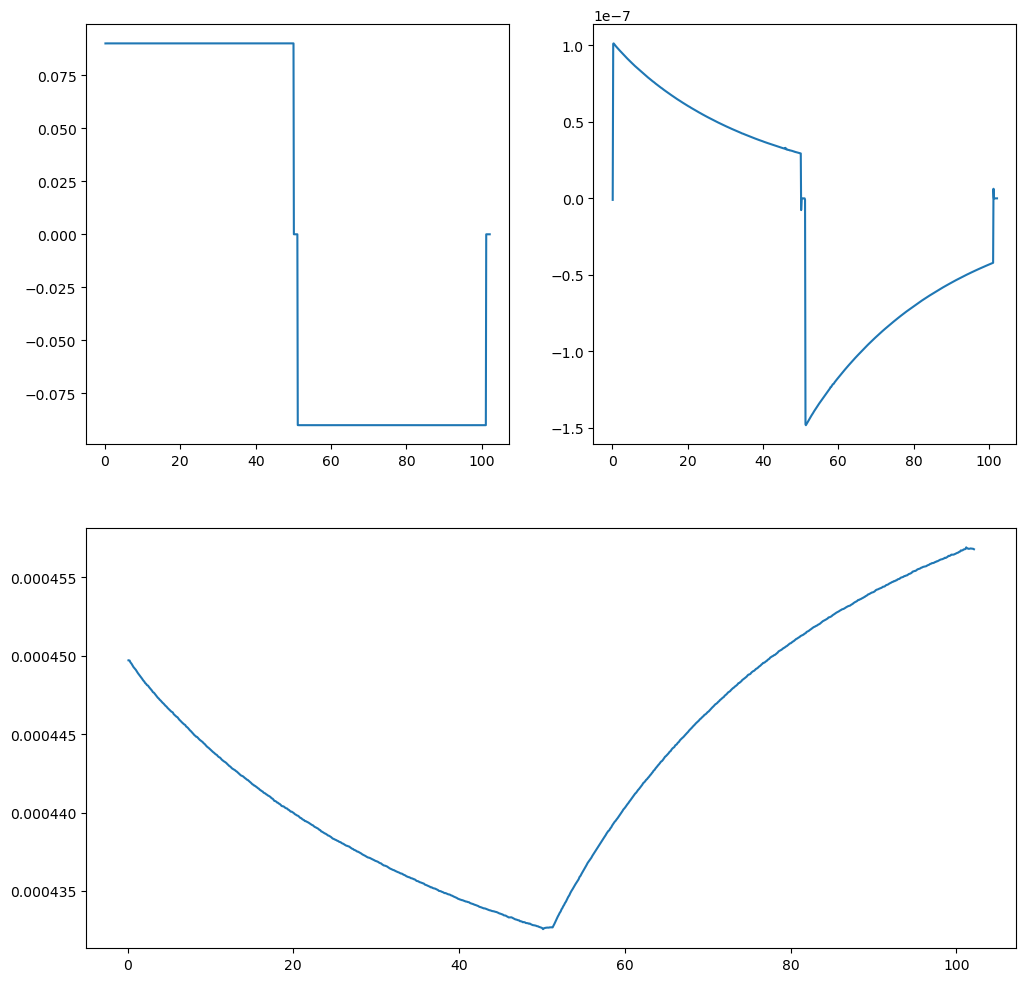

In [449]:
df = Load_Files([15])
df = Group_Gate_Voltage(df)
df_Plot(df)

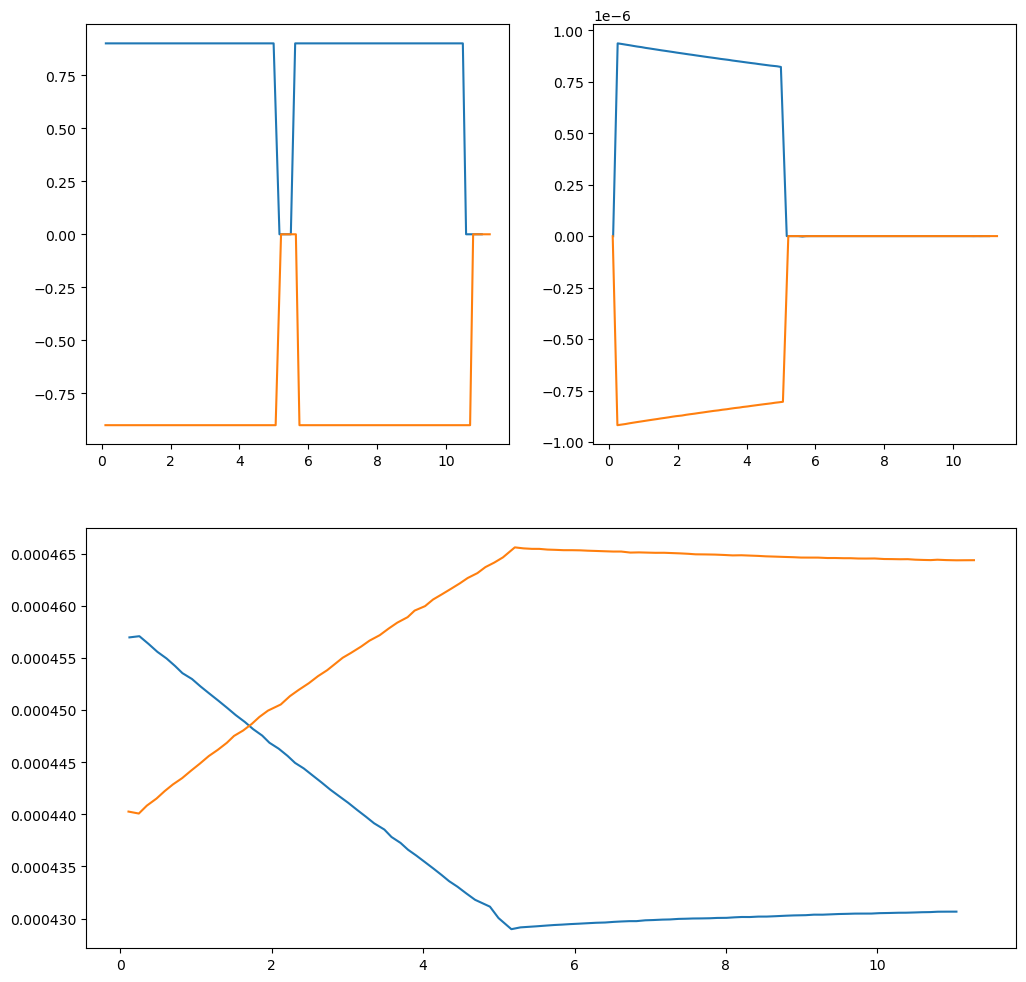

In [450]:
df = Load_Files([16, 18])
df = Group_Gate_Voltage(df)
df_Plot(df)

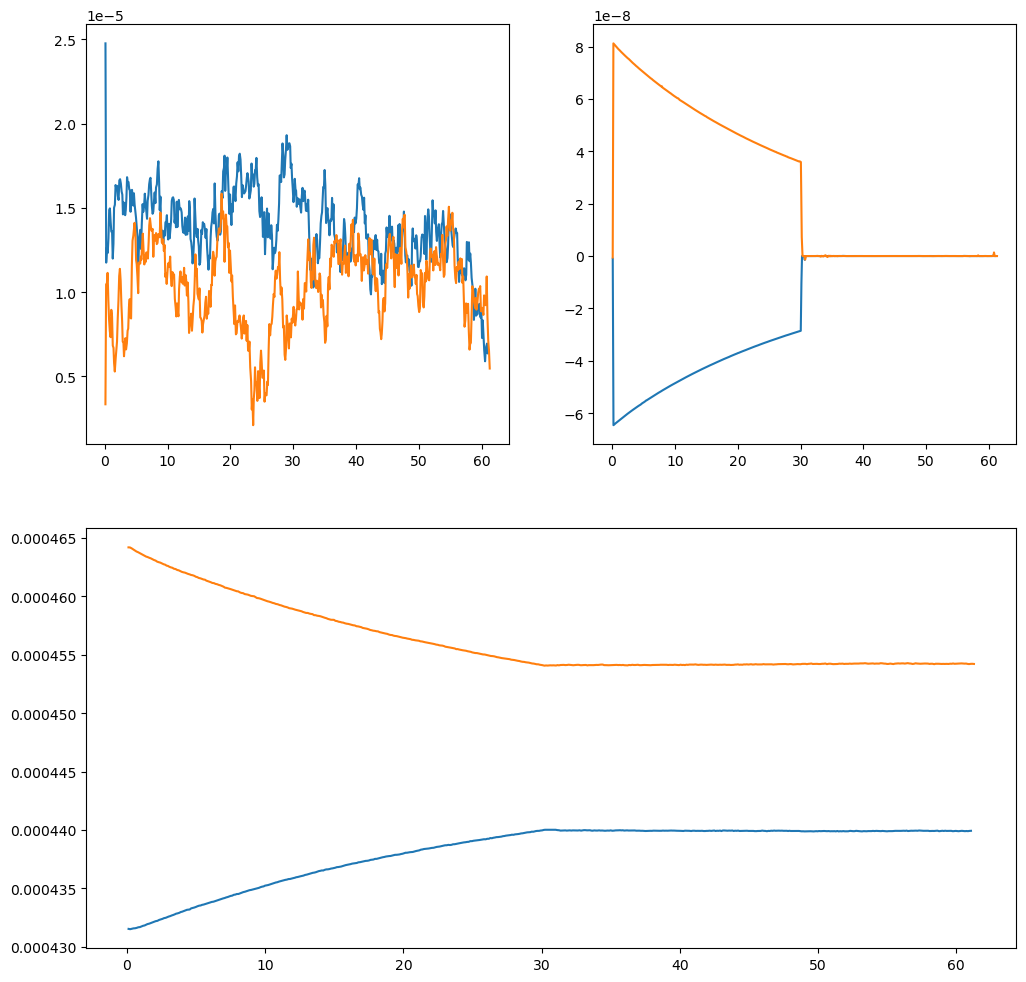

In [455]:
df = Load_Files([17, 19])
df = Group_Gate_Voltage(df)
df_Plot(df)